In [ ]:
%matplotlib inline

# AUTOMATIC DIAGNOSTIC SYSTEM OF SKIN LESSIONS FROM DERMOSCOPIC IMAGES


In this practice we are going to build a skin lesion diagnosis system based on dermoscopic image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Our goal is to develop a CNN providing an automatic diagnosis of cutaneous diseases from dermoscopic images. Dermoscopy is a non-invasive technique that allows the evaluation of the colors and microstructures of the epidermis, the dermoepidermal joint and the papillary dermis that are not visible to the naked eye. These structures are specifically correlated with histological properties of the lesions. Identifying specific visual patterns related to color distribution or dermoscopic structures can help dermatologists decide the malignancy of a pigmented lesion. The use of this technique provides a great help to the experts to support their diagnosis. However, the complexity of its analysis limits its application to experienced clinicians or dermatologists.

In our scenario, we will consider 3 classes of skin lesions:

- Malignant melanoma: Melanoma, also known as malignant melanoma, is the most common type of cancer, and arises from pigmented cells known as melanocytes. Melanomas typically occur on the skin and rarely elsewhere such as the mouth, intestines, or eye.

- Seborrheic keratosis: it is a noncancerous (benign) tumor of the skin that originates from the cells of the outer layer of the skin (keranocytes), so it is a non-melanocytic lesion.

- Benign nevus: a benign skin tumor caused by melanocytes (it is melanocytic)

Figure 1 shows a visual example of the 3 considered lesions:

![Image of ISIC](http://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

The dataset has been obtained from the 'Internatial Skin Imaging Collaboration' (ISIC) file. It contains 2750 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 150 images
- Test set: 600 images

For each clinical case, two images are available:
- The dermoscopic image of the lesion (in the ‘images’ folder).
- A binary mask with the segmentation between injury (mole) and skin (in the 'masks' folder)

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image and mask.
- the lesion label: available only for training and validation, being an integer between 0 and 2: 0: benign nevus, 1: malignant melanoma, 2: seborrheic keratosis. In the case of the test set, labels are not available (their value is -1).

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Fine-tuning a regular network for our diagnostic problem

## Part 1: Handling our custom dataset with pytorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import random
import pdb

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

 # Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Lo primero que vamos a hacer es descargar y descomprimir la base de datos a un directorio local de trabajo:




In [ ]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/iHealth/Computer vision/lab_6/db1.zip', '/db1.zip') #Copy db files to our working folder
copyfile('/content/drive/My Drive/iHealth/Computer vision/lab_6/db2.zip', '/db2.zip')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/db2.zip'

In [ ]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
import zipfile
zipPath='/db1.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)
    
zipPath='/db2.zip' #path of the 2nd zip file
dataFolder='./data' # We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 4-digit sequence, adding 0 to the left side if required)
- Label: 0 benign nevus, 1 melanoma, 2 seborrheic keratosis



In [ ]:
db = pd.read_csv('./data/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

#We show inform
n = 65
img_id = db.id[n] 
label = db.label[n]


print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))


Image ID: 0066
Label: 0


Now, let's create a simple function to show an image.




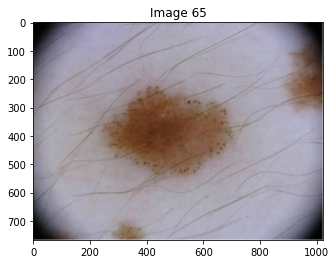

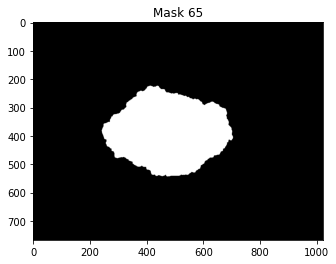

In [ ]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)        

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset is going to be a dictionary `` {'image': image, 'mask': mask, 'label': label} ``. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [ ]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,reducedSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})
        
        if reducedSize>0:
          idx=np.random.permutation(range(len(self.dataset)))
          reduced_dataset=self.dataset.iloc[idx[0:reducedSize]]
          self.dataset=reduced_dataset.reset_index(drop=True)
          
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images') 
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)
        
        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.long)}
        if self.transform:
            sample = self.transform(sample)
        return sample

We now instantiate the class to iterate over some samples to see what we generate.


0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


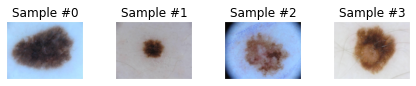

In [ ]:
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

### Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 4 transformations:

- `` CropByMask``: to crop the image using the lesion mask
- `` Rescale``: to scale the image
- `` RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
- `` ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [ ]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding 
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border
            
    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}
    
class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size. 
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}


class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0
            
        if w>new_w: 
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image.copy())
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask.copy())
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)
        
        return {'image':image,
                'mask':mask,
                'label':label}
    
class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means. 
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):
      
        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same' 
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])
    
        
        return {'image': image, 'mask': mask, 'label' : label}

class AddNoise(object):

    def __call__(self, sample):
      """
        Adds Gaussian Noise to the image.
      """
      a = np.random.binomial(1, 0.2, 1)
      image, mask, label = sample['image'], sample['mask'], sample['label']

      if a==1:
        h, w , ch = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(h,w,ch))
        gauss = gauss.reshape(h,w,ch)
        noisy = image + gauss
      
      else:
        noisy = image

      return {'image': noisy, 'mask': mask, 'label' : label}


class Rotate90(object):

    def __call__(self, sample):

      a = np.random.binomial(1, 0.2, 1)
      image, mask, label = sample['image'], sample['mask'], sample['label']

      if a==1:

        rotated_img = np.rot90(image)
        rotated_mask = np.rot90(mask)
        
        rotated_mask = np.reshape(rotated_mask, mask.shape)

      else:
        rotated_img = image
        rotated_mask = mask

      return {'image': rotated_img, 'mask': rotated_mask, 'label' : label}

class Flip(object):

    def __call__(self, sample):

      a = np.random.binomial(1, 0.2, 1)
      image, mask, label = sample['image'], sample['mask'], sample['label']

      if a==1:

        flipped_img = np.rot90(image)
        flipped_mask = np.rot90(mask)
        
        flipped_mask = np.reshape(flipped_mask, mask.shape)

      else:
        flipped_img = image
        flipped_mask = mask

      return {'image': flipped_img, 'mask': flipped_mask, 'label' : label}



### Composed Transforms

Now let's apply the different transformations to our images. 

We will rescale the images so that their smallest dimension is 256 and then make random crops of size 224. To compose the transformations ``Rescale`` and ``RandomCrop`` we can use ``torchvision.transforms.Compose``, which is a simple callable class.




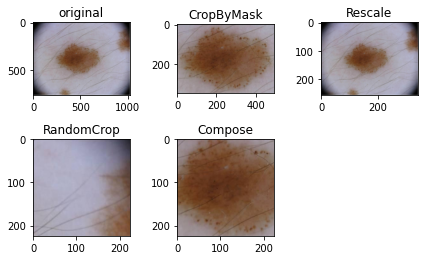

In [ ]:
cmask = CropByMask(15)
scale = Rescale(256)
crop = RandomCrop(224)
composed = transforms.Compose([CropByMask(15), Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(2,3, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
for i, tsfrm in enumerate([cmask, scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(2, 3, i + 2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

Iterating the dataset
-----------------------------

We can now put everything together to create the train and test datasets with the corresponding transformations.
In summary, every time we sample an image from the dataset (during training):
- We will read the image and the mask
- We will apply the transformations and we will crop the image using a bounding box computed from the mask
- As the final cropping operation is random, we perform data augmentation during sampling

We can easily iterate over the dataset with a ``for i in range`` loop.




In [ ]:

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    AddNoise(),
                                    #Rotate90(),
                                    Flip(),
                                    ToTensor(),
                                    Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ]))

#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(0)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(1)
3 torch.Size([3, 224, 224]) tensor(0)


Finally, we have to create a dataloader allowing to:

- Sample batches of samples to feed the network during training
- Shuffle data
- Load the data in parallel using multiple cores.

``torch.utils.data.DataLoader`` is an iterator that provides all these features. An important parameter of the iterator is ``collate_fn``. We can specify how samples are organized in batches by choosing the most appropriate function. In any case, the default option should work fine in most cases.




0 torch.Size([8, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 1, 0])
1 torch.Size([8, 3, 224, 224]) tensor([0, 2, 0, 0, 0, 0, 1, 0])
2 torch.Size([8, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0])
3 torch.Size([8, 3, 224, 224]) tensor([1, 2, 0, 0, 0, 1, 2, 0])


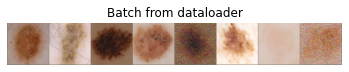

In [ ]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 4 workers
train_dataloader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, num_workers=4)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=256,
                        shuffle=False, num_workers=4)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers=4)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])

    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Part 2: Fine-tuning a pre-trained model

In the second part of the practice we will build an automatic skin lesion diagnosis system. Instead of training a CNN designed by us from the beginning, we will fine-tune a network that has previously been trained for another task. As seen in the lectures, this usually becomes a good alternative when we do not have many data in the training dataset (in relation to the parameters to be learned).

In particular, we will use the resnet-18 CNN, included in the ``torchvision`` package.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, and following the instructions of the organizers of the original ISIC challenge, we will use the area under the ROC or AUC, but we will calculate 3 different AUCs:
- 1) AUC of binary problem melanoma vs all
- 2) AUC of the binary problem seborrheic keratosis vs all
- 3) AUC average of the previous two

The following function computes AUCs from the complete database outputs:



In [ ]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset 
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores,labels):
                
    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(np.int) 
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(np.int) 
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)
    
    return aucs

### Training function

We continue defining the function to train our classifier:

In [ ]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    numClasses = len(image_datasets['train'].classes)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)

            
            #Dataset size
            numSamples = dataset_sizes[phase]
            
            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
            labels_m=np.zeros((numSamples,),dtype=np.int)
            running_loss = 0.0
            
            contSamples=0
            
            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)
                
                #Batch Size
                batchSize = labels.shape[0]
                
                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)
                
                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels 
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize
                
           
            
            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            
            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)
            
            #And the Average AUC
            epoch_auc = aucs.mean()

             #At the end of an epoch, update the lr scheduler    
            if phase == 'train':
                scheduler.step(epoch_auc)
                         
            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()        
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Include an auxiliary function to show some predictions:

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, sample in enumerate(dataloaders['val']):
            inputs = sample['image'].to(device).float()
            labels = sample['label'].to(device)
          
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
def test_model(model):
    since = time.time()
    
    numClasses = len(image_datasets['train'].classes)    
      
    for phase in ['test']:
        model.eval()   # Set the model in val mode (no grads)
        
        #Dataset size
        numSamples = dataset_sizes[phase]
        
        # Create variables to store outputs and labels
        outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
        labels_m=np.zeros((numSamples,),dtype=np.int)
        running_loss = 0.0
        
        contSamples=0
        
        # Iterate (loop of batches)
        for sample in dataloaders[phase]:
            inputs = sample['image'].to(device).float()
            labels = sample['label'].to(device)
            
            #Batch Size
            batchSize = labels.shape[0]
            
            outputs = model(inputs)
        
            #Apply a softmax to the output
            outputs=F.softmax(outputs.data,dim=1)

            # Store outputs and labels 
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
            contSamples+=batchSize
    
        print(outputs_m)
        np.savetxt('results_test.csv',outputs_m,delimiter=',')
       

### Fine-tuning of a pre-trained CNN
Once we have defined the training and evaluation functions, we will fine-tune the resnet-18 CNN using our database. In addition, we define the loss, the optimizer and the lr scheduler:

In [ ]:

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# We need to set-up the output layer (fully connected) to provide 3 scores (nevus, melanoma, y queratosis).
#model_ft.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model_ft.fc = nn.Sequential(
              nn.Linear(num_ftrs, 100),
              nn.ReLU(), 
              nn.Dropout(0.4),
             nn.Linear(100, len(train_dataset.classes))  )


#COnvert netowrk to GPU if available
model_ft = model_ft.to(device)

#The loss is a cross-entropy loss
criterion = nn.CrossEntropyLoss()

# We will use SGD with momentum as optimizer
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=1e-3)

# Our scheduler starts with an lr=1e-3 and decreases by a factor of 0.1 every 7 epochs.
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.1, patience=7)

### Set-up the data loaders
No we will assign the dataloaders over the training and validation data

In [ ]:
image_datasets = {'train' : train_dataset, 'val': val_dataset, 'test':test_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader, 'test':test_dataloader}
          
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test':len(test_dataset)}
class_names = image_datasets['train'].classes


### Train our network

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7666 AUC mel: 0.6438 sk: 0.7783 avg: 0.7111
val Loss: 0.7409 AUC mel: 0.7219 sk: 0.9277 avg: 0.8248

Epoch 1/24
----------
train Loss: 0.6837 AUC mel: 0.7064 sk: 0.8618 avg: 0.7841
val Loss: 0.7000 AUC mel: 0.7944 sk: 0.9444 avg: 0.8694

Epoch 2/24
----------
train Loss: 0.6070 AUC mel: 0.7750 sk: 0.9057 avg: 0.8403
val Loss: 0.6067 AUC mel: 0.8478 sk: 0.9535 avg: 0.9006

Epoch 3/24
----------
train Loss: 0.5898 AUC mel: 0.7854 sk: 0.9083 avg: 0.8468
val Loss: 0.6163 AUC mel: 0.8147 sk: 0.9526 avg: 0.8837

Epoch 4/24
----------
train Loss: 0.5435 AUC mel: 0.8082 sk: 0.9369 avg: 0.8726
val Loss: 0.5903 AUC mel: 0.8686 sk: 0.9464 avg: 0.9075

Epoch 5/24
----------
train Loss: 0.5164 AUC mel: 0.8342 sk: 0.9377 avg: 0.8860
val Loss: 0.5197 AUC mel: 0.8919 sk: 0.9548 avg: 0.9234

Epoch 6/24
----------
train Loss: 0.4809 AUC mel: 0.8528 sk: 0.9533 avg: 0.9031
val Loss: 0.5108 AUC mel: 0.8956 sk: 0.9599 avg: 0.9277

Epoch 7/24
----------
train Loss: 0.4587 

## Part 3: Evaluation (Important)
The evaluation of this practice will be done through a challenge. For this, students are asked the following to provide an output matrix for both the validation and test database using this code. The matrix will have a size 600x3, 600 lesions and the 3 classes considered in the problem. The matrix must be provided in csv format (with 3 numbers per row separated by ',').

In addition, students will submit a short report (1 side for the description, 1 side for references and figures if necessary) where they will describe the most important aspects of the proposed solution and include a table with the validation results achieved by their extensions/decisions. The objective of this report is for the teacher to assess the developments / extensions / decisions made by the students when optimizing their system. And the table is asked to demonstrate that, at least in validation, their decisions helped to improve the system performance.  You don't need to provide an absolute level of detail about the changes made, just list them, briefly discuss their purpose and show their impact in the table.

The deadline for delivery of the results file and the report is Monday May 11 at 22:00.



In [ ]:
test_model(model_ft)

[[0.08462931 0.90450573 0.01086493]
 [0.13388948 0.84683442 0.0192761 ]
 [0.58020329 0.05741716 0.36237955]
 ...
 [0.83018398 0.15202273 0.01779337]
 [0.98856401 0.00825238 0.00318362]
 [0.94808322 0.03340926 0.01850752]]
